# 4. AQC Unitary

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax

jax.config.update("jax_enable_x64", True)

In [21]:
from ropt_aqc.initialise_hamiltonians import get_hamiltonian_terms, build_matrix_from_terms

method = 'AQC-unitary'
num_sites = 6
degree = 2
n_repetitions = 5
n_id_layers = 0
evolution_time = 0.25

In [22]:
# Ising-1d
J=1.
g=0.75
h=0.6
system = 'ising-1d'

terms, params = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=J, g=g, h=h)

J = params['J']
h = params['h']
g = params['g']

In [23]:
from ropt_aqc.initialise_hamiltonians import hamiltonian_to_sparse_pauli_op
from qiskit.quantum_info import SparsePauliOp
from rustworkx.generators import path_graph
import numpy as np

hamiltonian = hamiltonian_to_sparse_pauli_op(terms, num_qubits=num_sites)
print('Hamiltonian: ', hamiltonian)

observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (num_sites // 2 - 1, num_sites // 2), 1.0)], num_qubits=num_sites
)
print("Observable:", observable)

coupling_map = path_graph(num_sites)


Hamiltonian:  SparsePauliOp(['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ', 'ZIIIII', 'XIIIII', 'IZIIII', 'IXIIII', 'IIZIII', 'IIXIII', 'IIIZII', 'IIIXII', 'IIIIZI', 'IIIIXI', 'IIIIIZ', 'IIIIIX'],
              coeffs=[1.  +0.j, 1.  +0.j, 1.  +0.j, 1.  +0.j, 1.  +0.j, 0.6 +0.j, 0.75+0.j,
 0.6 +0.j, 0.75+0.j, 0.6 +0.j, 0.75+0.j, 0.6 +0.j, 0.75+0.j, 0.6 +0.j,
 0.75+0.j, 0.6 +0.j, 0.75+0.j])
Observable: SparsePauliOp(['IIZZII'],
              coeffs=[1.+0.j])


This single Trotter step circuit will be repeated 256 times:


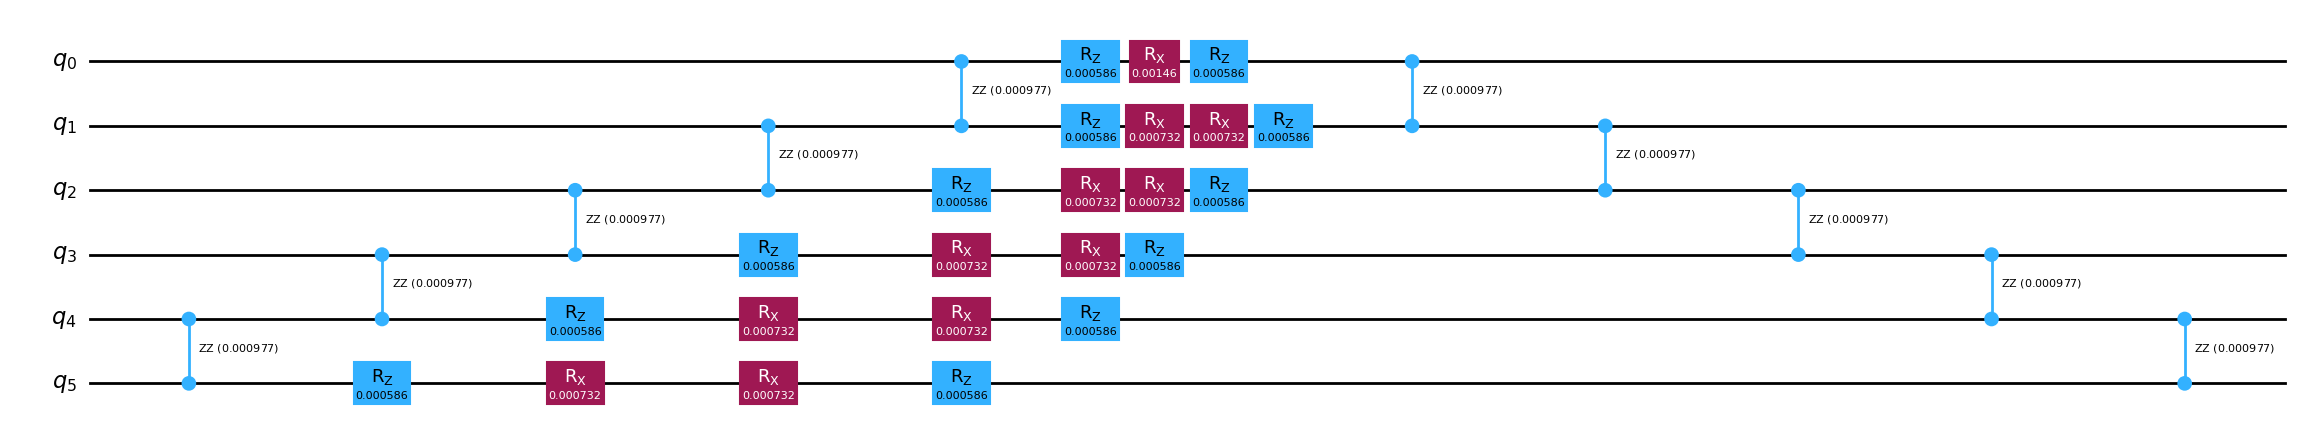

In [25]:
# Construct a single Trotter step of the target circuit
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

aqc_evolution_time = evolution_time
aqc_target_log2_num_trotter_steps = 8

aqc_target_step_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=1),
    time=aqc_evolution_time / 2**aqc_target_log2_num_trotter_steps,
)

print(
    f"This single Trotter step circuit will be repeated {2**aqc_target_log2_num_trotter_steps} times:"
)
aqc_target_step_circuit.draw("mpl", fold=-1)

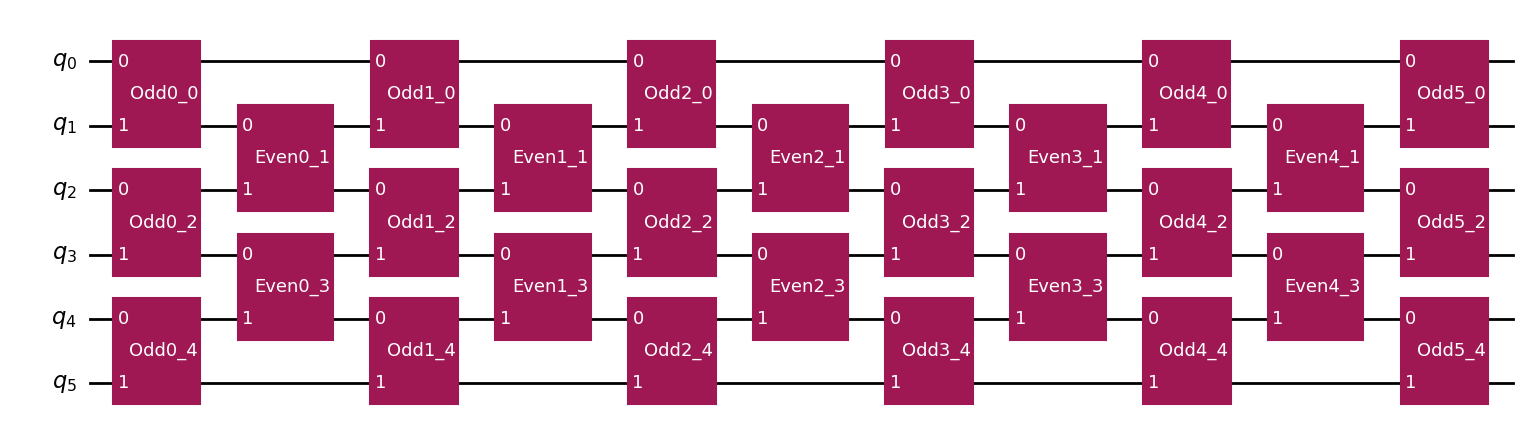

In [26]:
from ropt_aqc.spin_systems import get_brickwall_trotter_gates_spin_chain
from ropt_aqc.circuit_building import transform_to_bw_qc_unitarygate

gates_bw = get_brickwall_trotter_gates_spin_chain(t=evolution_time, n_sites=num_sites, n_repetitions=n_repetitions, hamiltonian=system, degree=degree, J=J, g=g, h=h)

bw_qc = transform_to_bw_qc_unitarygate(num_sites=num_sites, n_repetitions=n_repetitions, system = system, gates=gates_bw)
depth_initial = bw_qc.depth()
bw_qc.draw('mpl')

In [27]:
from qiskit_addon_aqc_tensor import generate_ansatz_from_circuit

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(
    bw_qc, parameter_name="x"
)

depth_anstaz = aqc_ansatz.depth()
print(depth_anstaz)


23


In [28]:
# Inspect number of gates
print("Total gates:", len(gates_bw))
expected_per_layer = (num_sites // 2)  # For even layers (1,2), (3,4), ...
if num_sites % 2 == 0:
    expected_odd = expected_per_layer
    expected_even = expected_per_layer - 1
else:
    expected_odd = expected_per_layer
    expected_even = expected_per_layer

# Count layers
odd_layers = []
even_layers = []
g_idx = 0
while g_idx < len(gates_bw):
    odd = gates_bw[g_idx : g_idx + expected_odd]
    g_idx += expected_odd
    even = gates_bw[g_idx : g_idx + expected_even]
    g_idx += expected_even
    odd_layers.append(odd)
    even_layers.append(even)

print("Odd layers:", len(odd_layers))
print("Even layers:", len(even_layers))


Total gates: 28
Odd layers: 6
Even layers: 6


In [29]:
# # construct a good cirucit

# ansatz_num_trotter_steps = 2

# aqc_good_circuit = generate_time_evolution_circuit(
#     hamiltonian,
#     synthesis=SuzukiTrotter(reps=ansatz_num_trotter_steps),
#     time=aqc_evolution_time,
# )
# # generate ansatz from a good circuit

# from qiskit_addon_aqc_tensor import generate_ansatz_from_circuit

# aqc_ansatz_i, aqc_initial_parameters_i = generate_ansatz_from_circuit(
#     aqc_good_circuit, parameter_name="x"
# )
# aqc_ansatz_i.assign_parameters(aqc_initial_parameters_i).draw("mpl", fold=-1)
# depth_i = aqc_ansatz_i.depth()
# print(depth_i)


In [30]:
# from qiskit.quantum_info import Operator
# import numpy as np

# U_qiskit = Operator(aqc_good_circuit).data
# U_brickwall = Operator(bw_qc).data

# phase = np.angle(np.vdot(U_qiskit.flatten(), U_brickwall.flatten()))
# U_aligned = U_brickwall * np.exp(-1j * phase)

# diff = np.linalg.norm(U_qiskit - U_aligned)
# print("F-norm after global phase correction:", diff)


In [31]:
# from qiskit.quantum_info import Operator
# import numpy as np

# # Get unitaries from both circuits
# U_qiskit = Operator(aqc_good_circuit).data
# U_brickwall = Operator(bw_qc).data

# # Compare using Frobenius norm
# diff = np.linalg.norm(U_qiskit - U_brickwall)
# print("||U_qiskit - U_brickwall||_F =", diff)

# # Optional: check global phase difference
# global_phase_diff = np.angle(np.trace(U_qiskit.conj().T @ U_brickwall)) / U_qiskit.shape[0]
# print("Estimated global phase difference:", global_phase_diff)

# print(np.linalg.norm(Operator(aqc_good_circuit) - Operator(bw_qc)))


In [32]:
# from qiskit.quantum_info import Statevector, state_fidelity

# init_sv = Statevector.from_label("0" * num_sites)

# out_sv_qiskit = init_sv.evolve(aqc_good_circuit)
# out_sv_bw = init_sv.evolve(bw_qc)

# fidelity = state_fidelity(out_sv_qiskit, out_sv_bw)
# print("Fidelity between outputs:", fidelity)


In [33]:
# set up quimb
from functools import partial
import quimb.tensor
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator

simulator_settings = QuimbSimulator(
    partial(quimb.tensor.Circuit, gate_contract="split-gate"),
    autodiff_backend="jax",
)

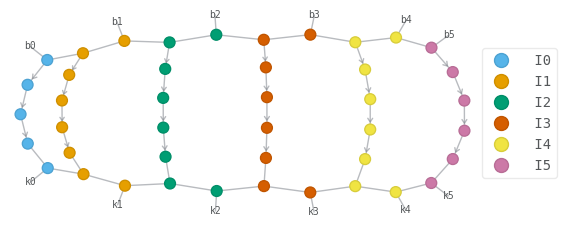

In [34]:
# construct target MPO - tensor network of single trotter step of target circuit
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit

aqc_target_mpo = tensornetwork_from_circuit(aqc_target_step_circuit, simulator_settings).get_uni()
aqc_target_mpo.draw(aqc_target_mpo.site_tags, show_tags=False)

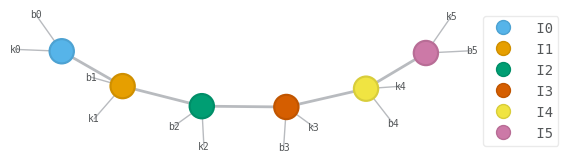

In [35]:
# contract and fuse multibonds to form MPO

for site in aqc_target_mpo.site_tags:
    aqc_target_mpo.contract(site, inplace=True)
aqc_target_mpo.fuse_multibonds_()

aqc_target_mpo.draw(aqc_target_mpo.site_tags, show_tags=False)

In [36]:
# cast to MPO object and compress

cutoff = 1e-8

aqc_target_mpo.view_as_(
    quimb.tensor.MatrixProductOperator,
    cyclic=False,
    L=coupling_map.num_nodes(),
)
aqc_target_mpo.compress(cutoff=cutoff)
aqc_target_mpo.show()

│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │


In [37]:
# repeatedly sqaure and compress MPO to represent an operator with many Trotter steps
for _ in range(aqc_target_log2_num_trotter_steps):
    aqc_target_mpo = aqc_target_mpo.apply(aqc_target_mpo)
    aqc_target_mpo.compress(cutoff=cutoff)
    aqc_target_mpo.show()
aqc_target_mpo

│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│3│3│3│3│3│
●─<─<─<─<─<
│ │ │ │ │ │
│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │


MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=4)

In [19]:
from scipy.optimize import OptimizeResult, minimize

from qiskit_addon_aqc_tensor.objective import MaximizeUnitaryFidelity

objective = MaximizeUnitaryFidelity(aqc_target_mpo, aqc_ansatz, simulator_settings)

stopping_point = 1e-4


def my_loss_function(*args):
    val, grad = objective.loss_function(*args)
    print(f"Evaluating loss function: {1 - val:.8}")
    return val, grad


def callback(intermediate_result: OptimizeResult):
    print(f"Intermediate result: Fidelity {1 - intermediate_result.fun:.8}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration


result = minimize(
    my_loss_function,
    aqc_initial_parameters,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": 100},
    callback=callback,
)
if result.status not in (
    0,
    1,
    99,
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(f"Optimization failed: {result.message} (status={result.status})")

print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

Evaluating loss function: 0.01953228
Evaluating loss function: 0.39955218
Evaluating loss function: 0.045188283
Intermediate result: Fidelity 0.045188283
Evaluating loss function: 0.016054371
Evaluating loss function: 0.083690371
Intermediate result: Fidelity 0.083690371
Evaluating loss function: 0.17721176
Intermediate result: Fidelity 0.17721176
Evaluating loss function: 0.20221617
Intermediate result: Fidelity 0.20221617
Evaluating loss function: 0.2527775
Intermediate result: Fidelity 0.2527775
Evaluating loss function: 0.3081229
Intermediate result: Fidelity 0.3081229
Evaluating loss function: 0.37153211
Intermediate result: Fidelity 0.37153211
Evaluating loss function: 0.43182599
Intermediate result: Fidelity 0.43182599
Evaluating loss function: 0.49895454
Intermediate result: Fidelity 0.49895454
Evaluating loss function: 0.55777333
Intermediate result: Fidelity 0.55777333
Evaluating loss function: 0.63794408
Intermediate result: Fidelity 0.63794408
Evaluating loss function: 0.69

=== Complete Optimised Circuit ===


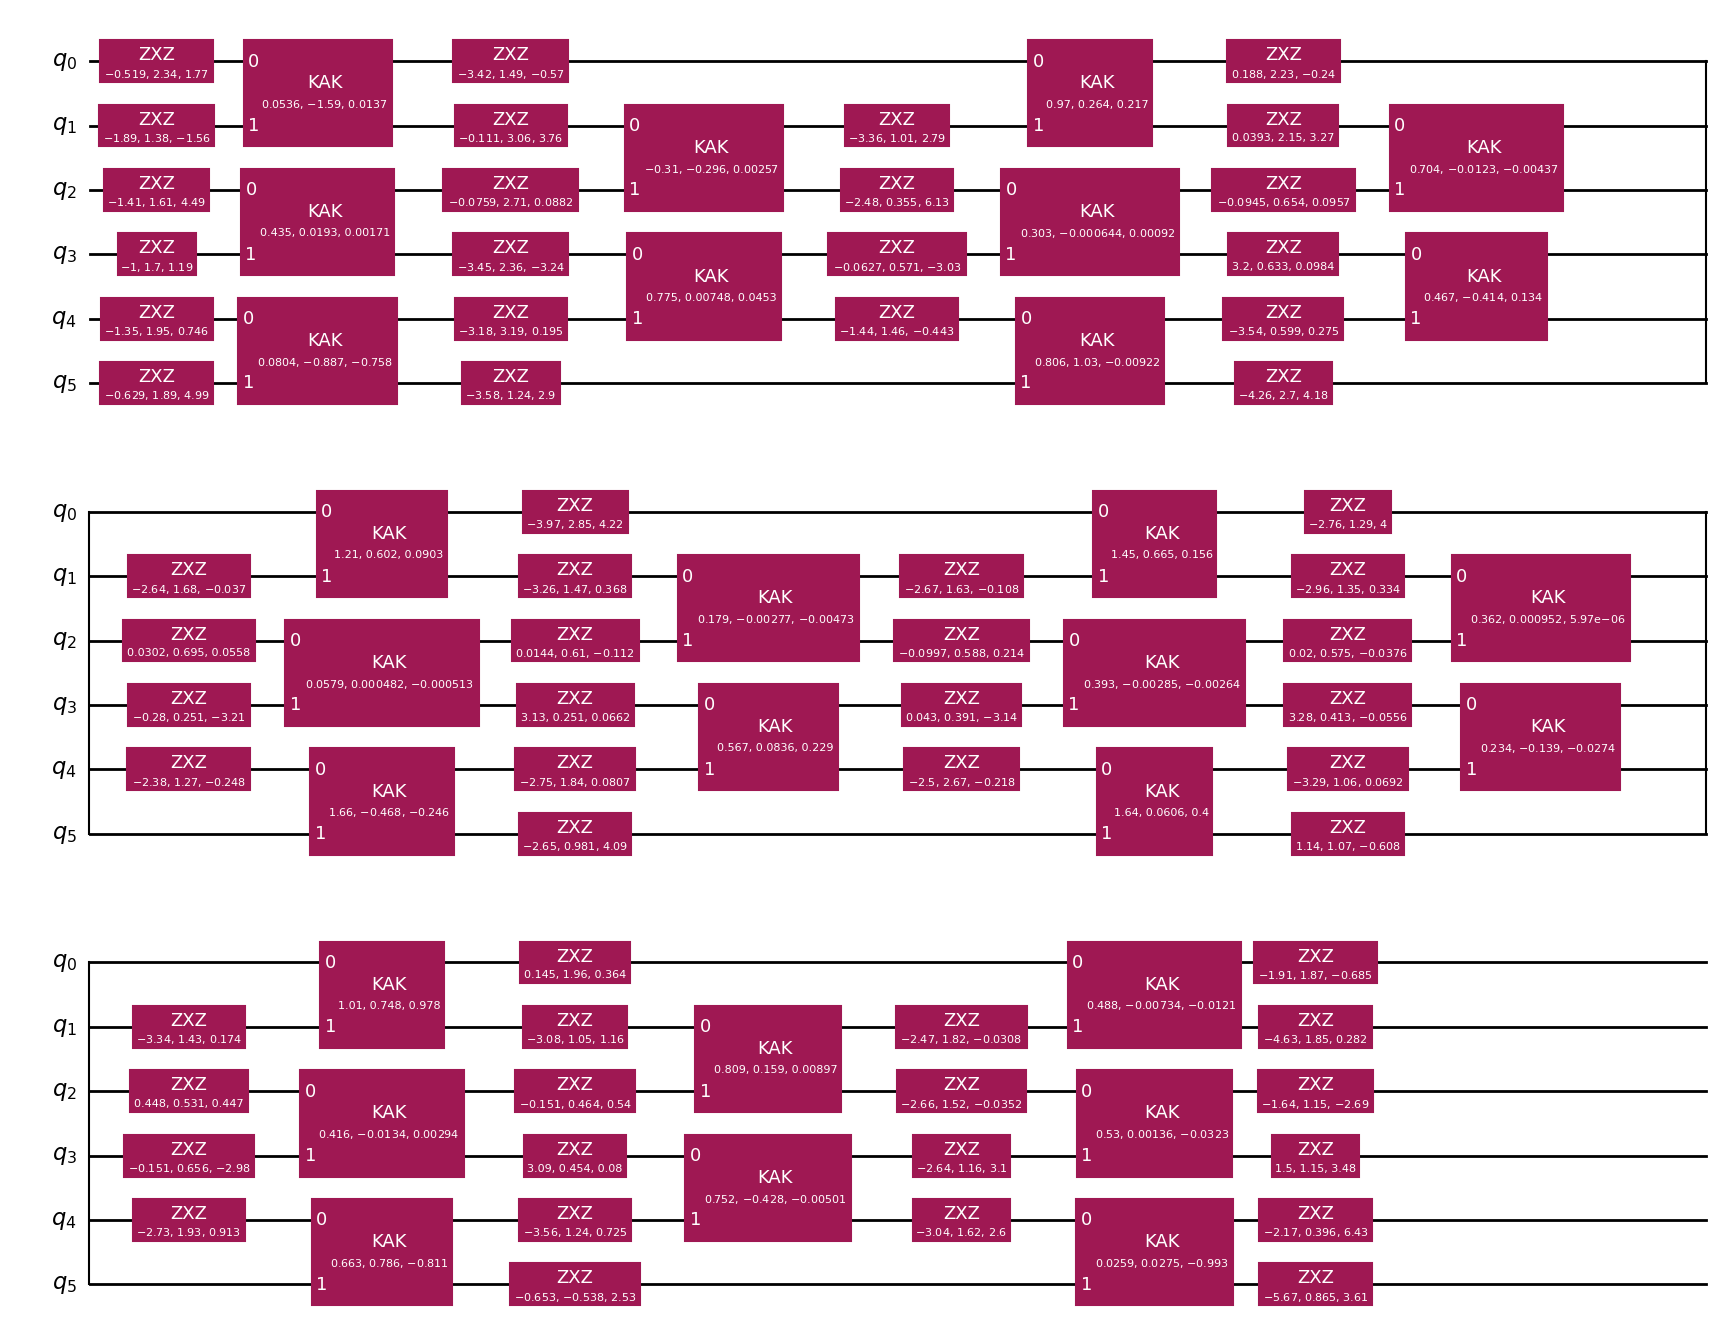

In [20]:
# from the optimised circuit 
aqc_optimised_block = aqc_ansatz.assign_parameters(aqc_final_parameters)
print("=== Complete Optimised Circuit ===")
aqc_optimised_block.draw("mpl")

In [21]:
depth_anstaz_opt = aqc_optimised_block.depth()
print(depth_anstaz_opt)

23


In [22]:
# calculate Frobenius inner product 
import numpy as np
from qiskit.quantum_info import Operator

if coupling_map.num_nodes() <= 8:
    target_operator = Operator(aqc_target_step_circuit).power(2**aqc_target_log2_num_trotter_steps)
    
    initial_fidelity = abs(
        np.trace(Operator(bw_qc).conjugate().to_matrix() @ target_operator.to_matrix())
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Initial Frobenius inner product: {initial_fidelity:.8}")

    final_fidelity = abs(
        np.trace(
            Operator(aqc_optimised_block).conjugate().to_matrix() @ target_operator.to_matrix()
        )
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Final Frobenius inner product: {final_fidelity:.8}")

Initial Frobenius inner product: 0.019697087
Final Frobenius inner product: 0.99487884


The final circuit implements evolution of the Hamiltonian for time = 8.0.


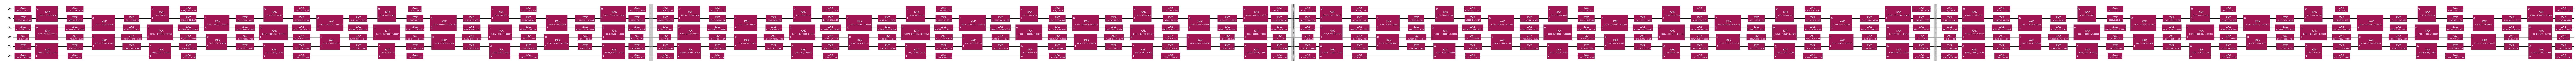

In [23]:
# Form final circuit by repeating the block
num_repeats = 4

print(
    f"The final circuit implements evolution of the Hamiltonian for time = {num_repeats * aqc_evolution_time}."
)  # FIXME: can i say anything about the fidelity??  ignoring cutoff/roundoff error of course
final_circuit = aqc_optimised_block.repeat(num_repeats)

aqc_optimised_block.repeat(num_repeats, insert_barriers=True).decompose().draw("mpl", fold=-1)

In [39]:
# Now slice and compress
from ropt_aqc.comparison_methods import compress_AQC_unitary

N_vals = range(1, 23+1)
df, aqc_ansatz, aqc_initial_parameters, aqc_final_parameters = compress_AQC_unitary(aqc_ansatz, aqc_initial_parameters, aqc_target_mpo, N_vals, simulator_settings, n_repetitions)


=== Optimising with N = 1 layers ===
Evaluating fidelity: 0.00143992
Intermediate result: Fidelity 0.0014399195
Evaluating fidelity: 0.00147250
Intermediate result: Fidelity 0.0014724993
Evaluating fidelity: 0.00150534
Intermediate result: Fidelity 0.0015053365
Evaluating fidelity: 0.00153843
Intermediate result: Fidelity 0.0015384265
Evaluating fidelity: 0.00157177
Intermediate result: Fidelity 0.0015717653
Evaluating fidelity: 0.00160535
Intermediate result: Fidelity 0.0016053493
Evaluating fidelity: 0.00163918
Intermediate result: Fidelity 0.0016391752
Evaluating fidelity: 0.00167324
Intermediate result: Fidelity 0.0016732403
Evaluating fidelity: 0.00170754
Intermediate result: Fidelity 0.0017075419
Evaluating fidelity: 0.00174208
Intermediate result: Fidelity 0.0017420777
Evaluating fidelity: 0.00177685
Intermediate result: Fidelity 0.0017768457
Evaluating fidelity: 0.00181184
Intermediate result: Fidelity 0.001811844
Evaluating fidelity: 0.00184707
Intermediate result: Fidelity 0

KeyboardInterrupt: 

In [25]:
import pandas as pd
file_path_ising = f'/Users/aag/Documents/ropt-aqc/method_comparison/results/AQC_unitary__bw_Ising_results_{evolution_time}.csv'

df.to_csv(file_path_ising, index=False, header=True)
# df.to_csv(file_path_ising, index=False, mode="a", header=False)


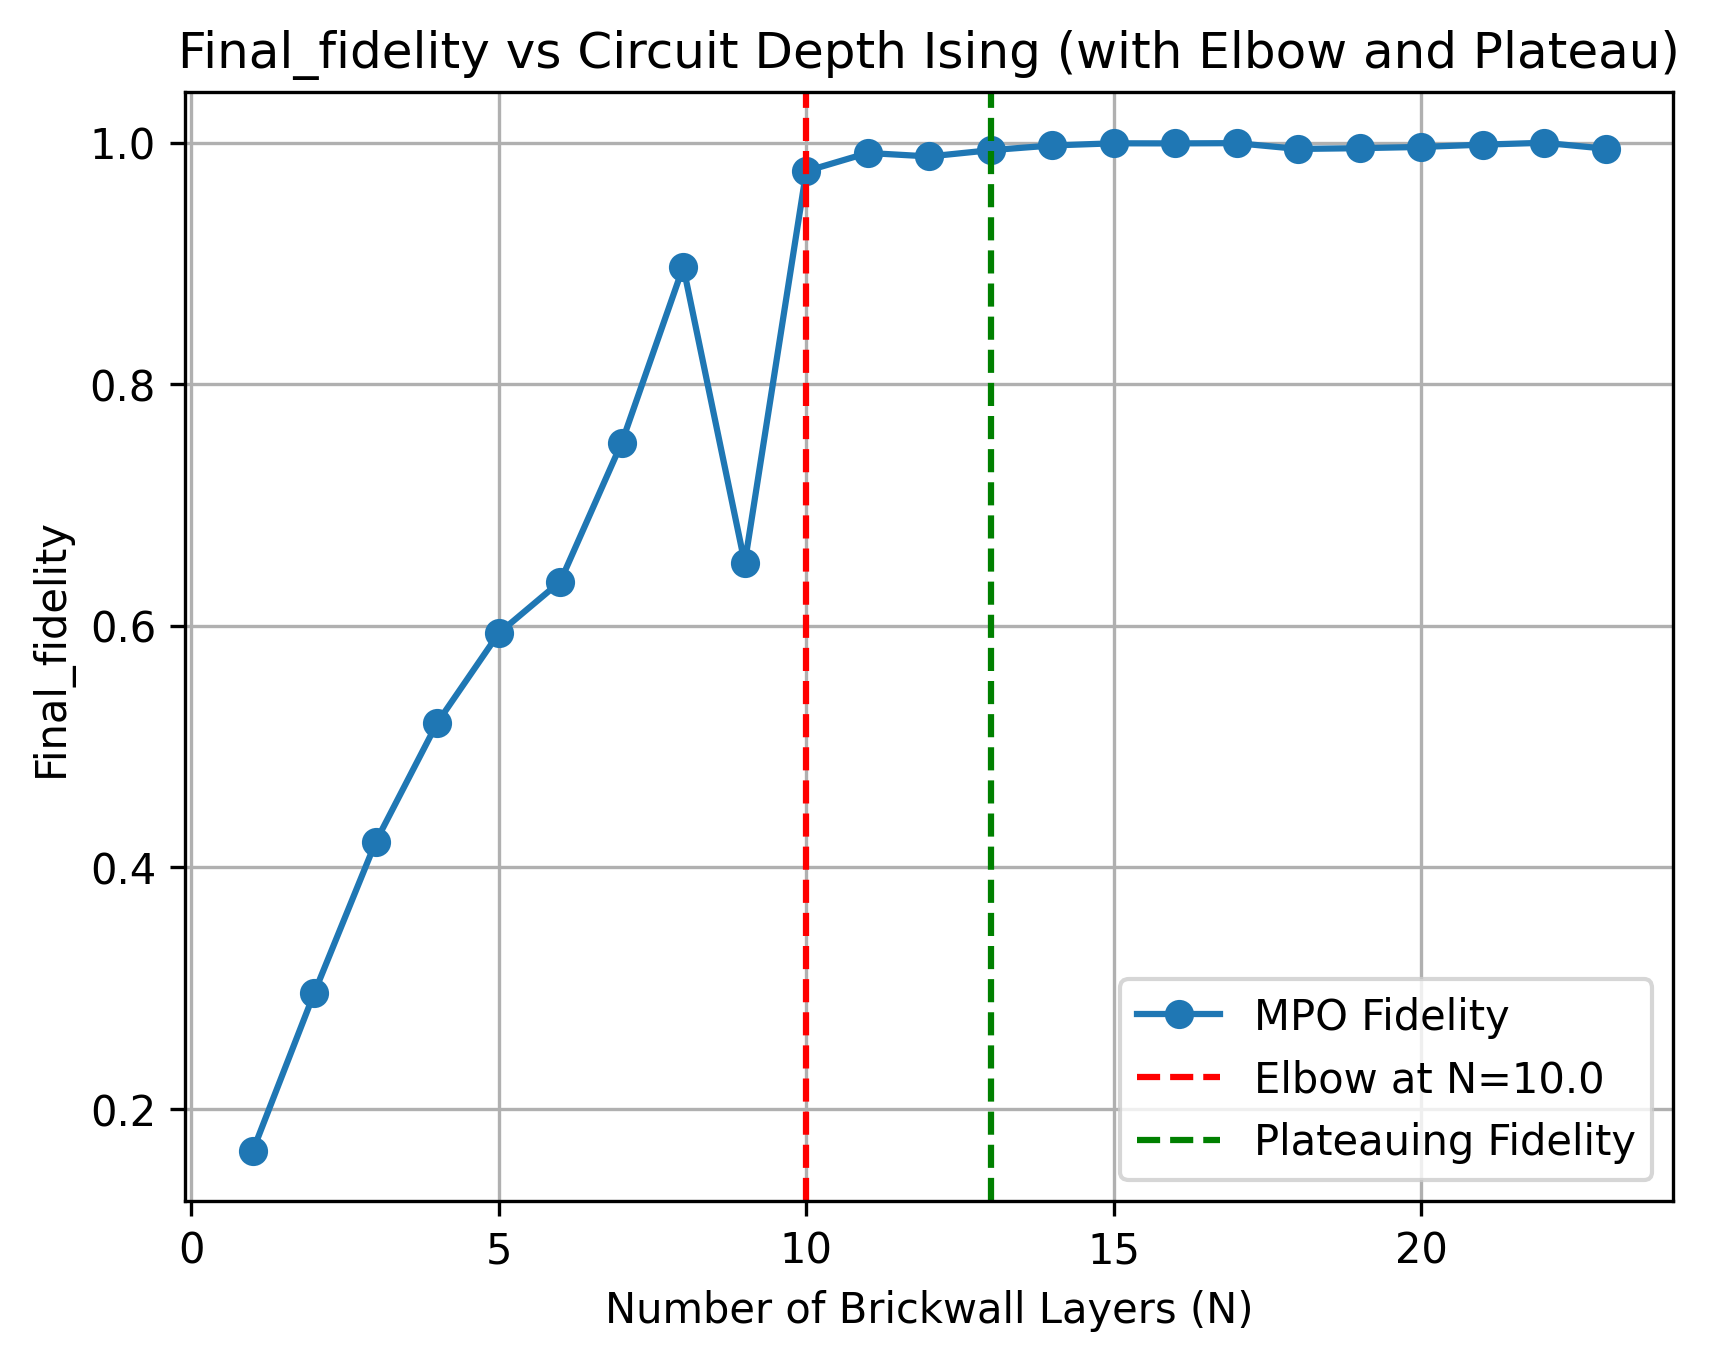


🔍 Suggested optimal compression depth: N = 13.0


In [26]:
from ropt_aqc.brickwall_opt import plot_fidelity
df = pd.read_csv(file_path_ising)

elbow_N, plateau_N = plot_fidelity(df, 'Final_fidelity', evolution_time, 1e-2, method, system, save_path=True)

In [28]:
# Compress circuit
from ropt_aqc.comparison_methods import compress_AQC_unitary

N_vals = [int(plateau_N)]
df_compressed, aqc_ansatz_compressed, aqc_initial_parameters_compressed, aqc_final_parameters_compressed = compress_AQC_unitary(aqc_ansatz, aqc_initial_parameters, bw_qc, aqc_target_mpo, N_vals, simulator_settings, n_repetitions)


=== Optimizing with N = 13 layers ===
Evaluating loss function: 0.050028528
Evaluating loss function: 0.17389753
Intermediate result: Fidelity 0.17389753
Evaluating loss function: 0.21955882
Intermediate result: Fidelity 0.21955882
Evaluating loss function: 0.30971903
Intermediate result: Fidelity 0.30971903
Evaluating loss function: 0.38847956
Intermediate result: Fidelity 0.38847956
Evaluating loss function: 0.0070799308
Evaluating loss function: 0.46387587
Intermediate result: Fidelity 0.46387587
Evaluating loss function: 0.51767894
Intermediate result: Fidelity 0.51767894
Evaluating loss function: 0.59119413
Intermediate result: Fidelity 0.59119413
Evaluating loss function: 0.62571564
Intermediate result: Fidelity 0.62571564
Evaluating loss function: 0.63920558
Intermediate result: Fidelity 0.63920558
Evaluating loss function: 0.65154138
Intermediate result: Fidelity 0.65154138
Evaluating loss function: 0.65886124
Intermediate result: Fidelity 0.65886124
Evaluating loss function: 

In [29]:
print("=== Compressed Optimised Circuit ===")

param_binding = {param: value for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed)}
aqc_optimised_compressed = aqc_ansatz_compressed.assign_parameters(param_binding)

aqc_optimised_compressed.draw("mpl")
aqc_optimised_compressed.draw("mpl").savefig('optimised_circuit_AQC_bw-u_Ising.pdf')

=== Compressed Optimised Circuit ===


In [30]:
print("\n=== Compressed Optimised Parameters ===")
import pandas as pd
for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed):
    print(f"{param}: {value:.6f}")

df_params = pd.DataFrame({'parameters': aqc_final_parameters_compressed})
df_params.to_csv('aqc_unitary_parameters_Ising.csv', index=False)


=== Compressed Optimised Parameters ===
x[0]: -2.105823
x[1]: 1.176801
x[2]: 1.233844
x[3]: -1.726878
x[4]: 1.509071
x[5]: -1.908560
x[6]: -1.320809
x[7]: 1.585553
x[8]: 4.310983
x[9]: -1.474605
x[10]: 1.524436
x[11]: 1.157450
x[12]: -2.685692
x[13]: 1.079330
x[14]: 1.489565
x[15]: -2.365907
x[16]: 2.866640
x[17]: 3.655567
x[18]: 0.536613
x[19]: 0.008898
x[20]: 0.004075
x[21]: -3.891824
x[22]: 1.230321
x[23]: -0.548279
x[24]: -0.055862
x[25]: 2.266794
x[26]: 3.909792
x[27]: 0.550092
x[28]: 0.016273
x[29]: -0.000691
x[30]: -0.107917
x[31]: 2.757671
x[32]: 0.593055
x[33]: -3.162543
x[34]: 2.691039
x[35]: -2.788221
x[36]: 0.160888
x[37]: 0.002332
x[38]: -1.424448
x[39]: -3.157090
x[40]: 4.932963
x[41]: 0.124755
x[42]: -3.638290
x[43]: 1.066783
x[44]: 2.828002
x[45]: 0.886882
x[46]: 0.246780
x[47]: -0.000401
x[48]: -3.126039
x[49]: 2.236385
x[50]: 2.863039
x[51]: -2.511097
x[52]: 0.880654
x[53]: 5.226229
x[54]: 0.835510
x[55]: -0.071111
x[56]: -0.001483
x[57]: -0.703587
x[58]: 0.893313
x[

In [31]:
print(f"Number of parameters in ansatz: {len(aqc_ansatz_compressed.parameters)}")
print(f"Physical depth of compressed circuit: {aqc_optimised_compressed.depth()}")
print(f"Compression ratio: {35 / aqc_optimised_compressed.depth()}")

Number of parameters in ansatz: 153
Physical depth of compressed circuit: 13
Compression ratio: 2.6923076923076925


# Heisenberg

In [13]:
# Heisenberg
t = 0.25
h = 0.75
system = 'heisenberg'

terms_h, params_h = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=[1.0, 1.0, -0.5], h=[0.75, 0.0, 0.0])

J= params_h['J']
h= params_h['h']

In [14]:
from ropt_aqc.initialise_hamiltonians import hamiltonian_to_sparse_pauli_op
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import CouplingMap

hamiltonian_heisenberg = hamiltonian_to_sparse_pauli_op(terms_h, num_qubits=num_sites)
print('Hamiltonian: ', hamiltonian_heisenberg)

observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (num_sites // 2 - 1, num_sites // 2), 1.0)], num_qubits=num_sites
)
print("Observable:", observable)

coupling_map = path_graph(num_sites)

Hamiltonian:  SparsePauliOp(['XXIIII', 'YYIIII', 'ZZIIII', 'IXXIII', 'IYYIII', 'IZZIII', 'IIXXII', 'IIYYII', 'IIZZII', 'IIIXXI', 'IIIYYI', 'IIIZZI', 'IIIIXX', 'IIIIYY', 'IIIIZZ', 'XIIIII', 'IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'IIIIIX'],
              coeffs=[ 1.  +0.j,  1.  +0.j, -0.5 +0.j,  1.  +0.j,  1.  +0.j, -0.5 +0.j,
  1.  +0.j,  1.  +0.j, -0.5 +0.j,  1.  +0.j,  1.  +0.j, -0.5 +0.j,
  1.  +0.j,  1.  +0.j, -0.5 +0.j,  0.75+0.j,  0.75+0.j,  0.75+0.j,
  0.75+0.j,  0.75+0.j,  0.75+0.j])
Observable: SparsePauliOp(['IIZZII'],
              coeffs=[1.+0.j])


This single Trotter step circuit will be repeated 1024 times:


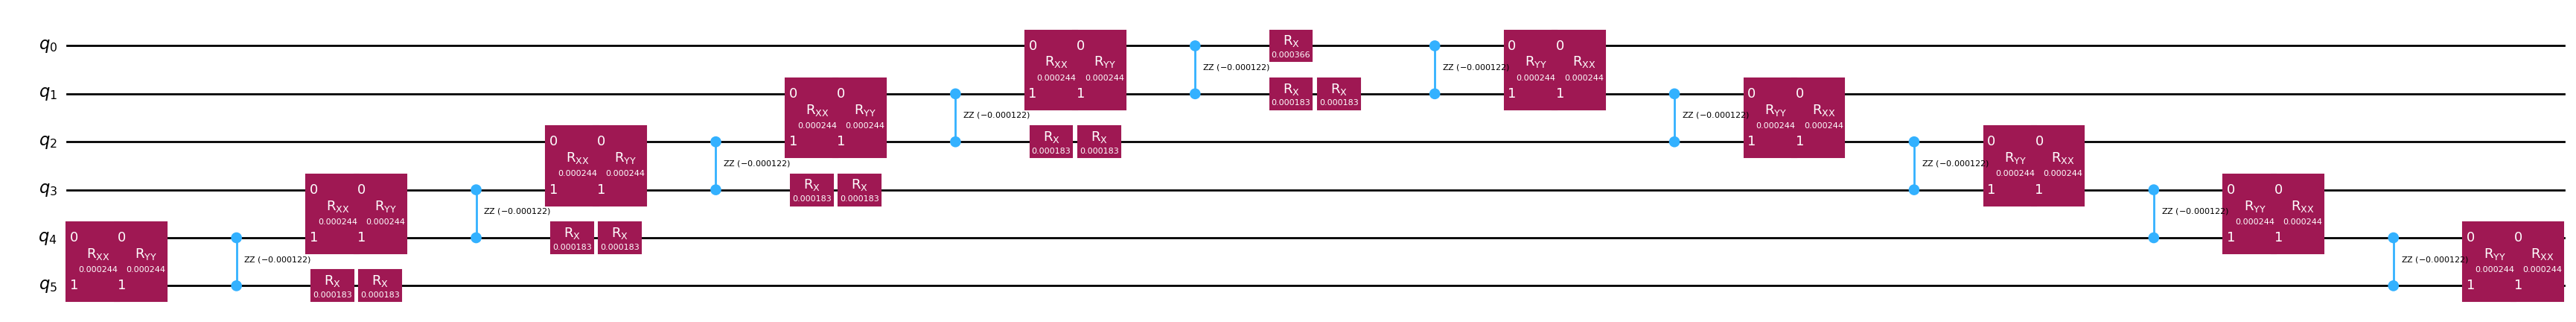

In [15]:
# Construct a single Trotter step of the target circuit
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

aqc_evolution_time = t
aqc_target_log2_num_trotter_steps = 10

aqc_target_step_circuit_h = generate_time_evolution_circuit(
    hamiltonian_heisenberg,
    synthesis=SuzukiTrotter(reps=1),
    time=aqc_evolution_time / 2**aqc_target_log2_num_trotter_steps,
)

print(
    f"This single Trotter step circuit will be repeated {2**aqc_target_log2_num_trotter_steps} times:"
)
aqc_target_step_circuit_h.draw("mpl", fold=-1)

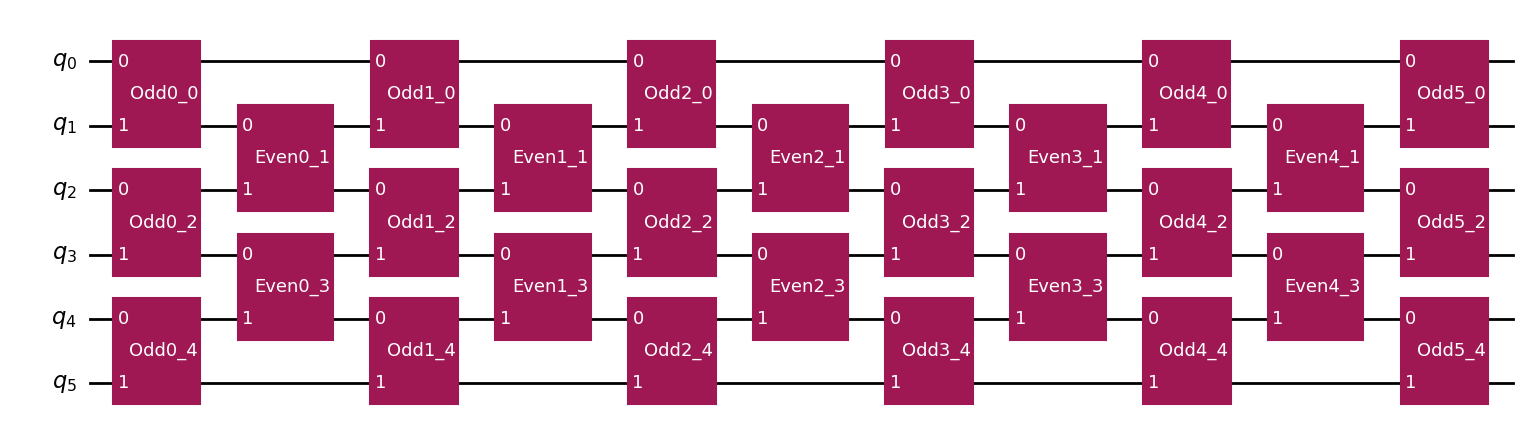

In [16]:
from ropt_aqc.spin_systems import get_brickwall_trotter_gates_spin_chain
from ropt_aqc.circuit_building import transform_to_bw_qc_unitarygate

gates_bw_h = get_brickwall_trotter_gates_spin_chain(t=evolution_time, n_sites=num_sites, n_repetitions=n_repetitions, hamiltonian=system, degree=degree, J=J, h=h)

bw_qc_h = transform_to_bw_qc_unitarygate(num_sites=num_sites, system = system, gates=gates_bw_h, pauli_terms=terms_h)
depth_h = bw_qc_h.depth()
bw_qc_h.draw('mpl')

In [51]:
from qiskit_addon_aqc_tensor import generate_ansatz_from_circuit

aqc_ansatz_h, aqc_initial_parameters_h = generate_ansatz_from_circuit(
    bw_qc_h, parameter_name="x"
)

depth_h = aqc_ansatz_h.depth()
print(depth_h)


23


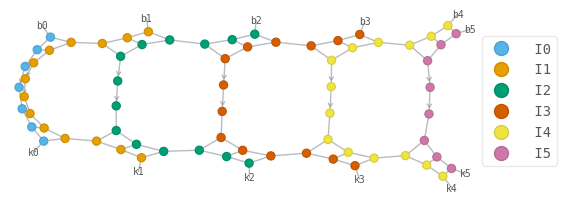

In [52]:
# construct target MPO - tensor network of single trotter step of target circuit
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit

aqc_target_mpo_h = tensornetwork_from_circuit(aqc_target_step_circuit_h, simulator_settings).get_uni()
aqc_target_mpo_h.draw(aqc_target_mpo_h.site_tags, show_tags=False)

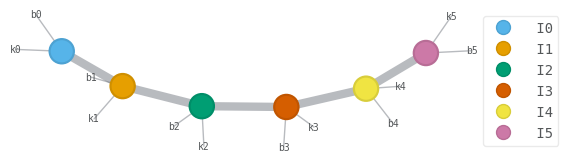

In [53]:
# contract and fuse multibonds to form MPO

for site in aqc_target_mpo_h.site_tags:
    aqc_target_mpo_h.contract(site, inplace=True)
aqc_target_mpo_h.fuse_multibonds_()

aqc_target_mpo_h.draw(aqc_target_mpo_h.site_tags, show_tags=False)

In [54]:
# cast to MPO object and compress
cutoff = 1e-8

aqc_target_mpo_h.view_as_(
    quimb.tensor.MatrixProductOperator,
    cyclic=False,
    L=coupling_map.num_nodes(),
)
aqc_target_mpo_h.compress(cutoff=cutoff)
aqc_target_mpo_h.show()

│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │


In [55]:
# repeatedly sqaure and compress MPO to represent an operator with many Trotter steps
for _ in range(aqc_target_log2_num_trotter_steps):
    aqc_target_mpo_h = aqc_target_mpo_h.apply(aqc_target_mpo_h)
    aqc_target_mpo_h.compress(cutoff=cutoff)
    aqc_target_mpo_h.show()
aqc_target_mpo_h

│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│5│5│5│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│10│10│10│4│
●─<──<──<──<─<
│ │  │  │  │ │
│4│16│16│16│4│
●─<──<──<──<─<
│ │  │  │  │ │


MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=16)

In [56]:
from scipy.optimize import OptimizeResult, minimize

from qiskit_addon_aqc_tensor.objective import MaximizeUnitaryFidelity

objective = MaximizeUnitaryFidelity(aqc_target_mpo_h, aqc_ansatz_h, simulator_settings)

stopping_point = 1e-4


def my_loss_function(*args):
    val, grad = objective.loss_function(*args)
    print(f"Evaluating loss function: {1 - val:.8}")
    return val, grad


def callback(intermediate_result: OptimizeResult):
    print(f"Intermediate result: Fidelity {1 - intermediate_result.fun:.8}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration


result_h = minimize(
    my_loss_function,
    aqc_initial_parameters_h,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": 100},
    callback=callback,
)
if result_h.status not in (
    0,
    1,
    99,
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(f"Optimization failed: {result_h.message} (status={result_h.status})")

print(f"Done after {result_h.nit} iterations.")
aqc_final_parameters_h = result_h.x

Evaluating loss function: 0.090484249
Evaluating loss function: 0.13285365
Intermediate result: Fidelity 0.13285365
Evaluating loss function: 0.28628954
Intermediate result: Fidelity 0.28628954
Evaluating loss function: 0.31249071
Intermediate result: Fidelity 0.31249071
Evaluating loss function: 0.42521132
Intermediate result: Fidelity 0.42521132
Evaluating loss function: 0.51220634
Intermediate result: Fidelity 0.51220634
Evaluating loss function: 0.60951246
Intermediate result: Fidelity 0.60951246
Evaluating loss function: 0.66861864
Intermediate result: Fidelity 0.66861864
Evaluating loss function: 0.82658262
Intermediate result: Fidelity 0.82658262
Evaluating loss function: 0.89162228
Intermediate result: Fidelity 0.89162228
Evaluating loss function: 0.93338471
Intermediate result: Fidelity 0.93338471
Evaluating loss function: 0.9711687
Intermediate result: Fidelity 0.9711687
Evaluating loss function: 0.98345752
Intermediate result: Fidelity 0.98345752
Evaluating loss function: 0.

=== Complete Optimised Circuit ===


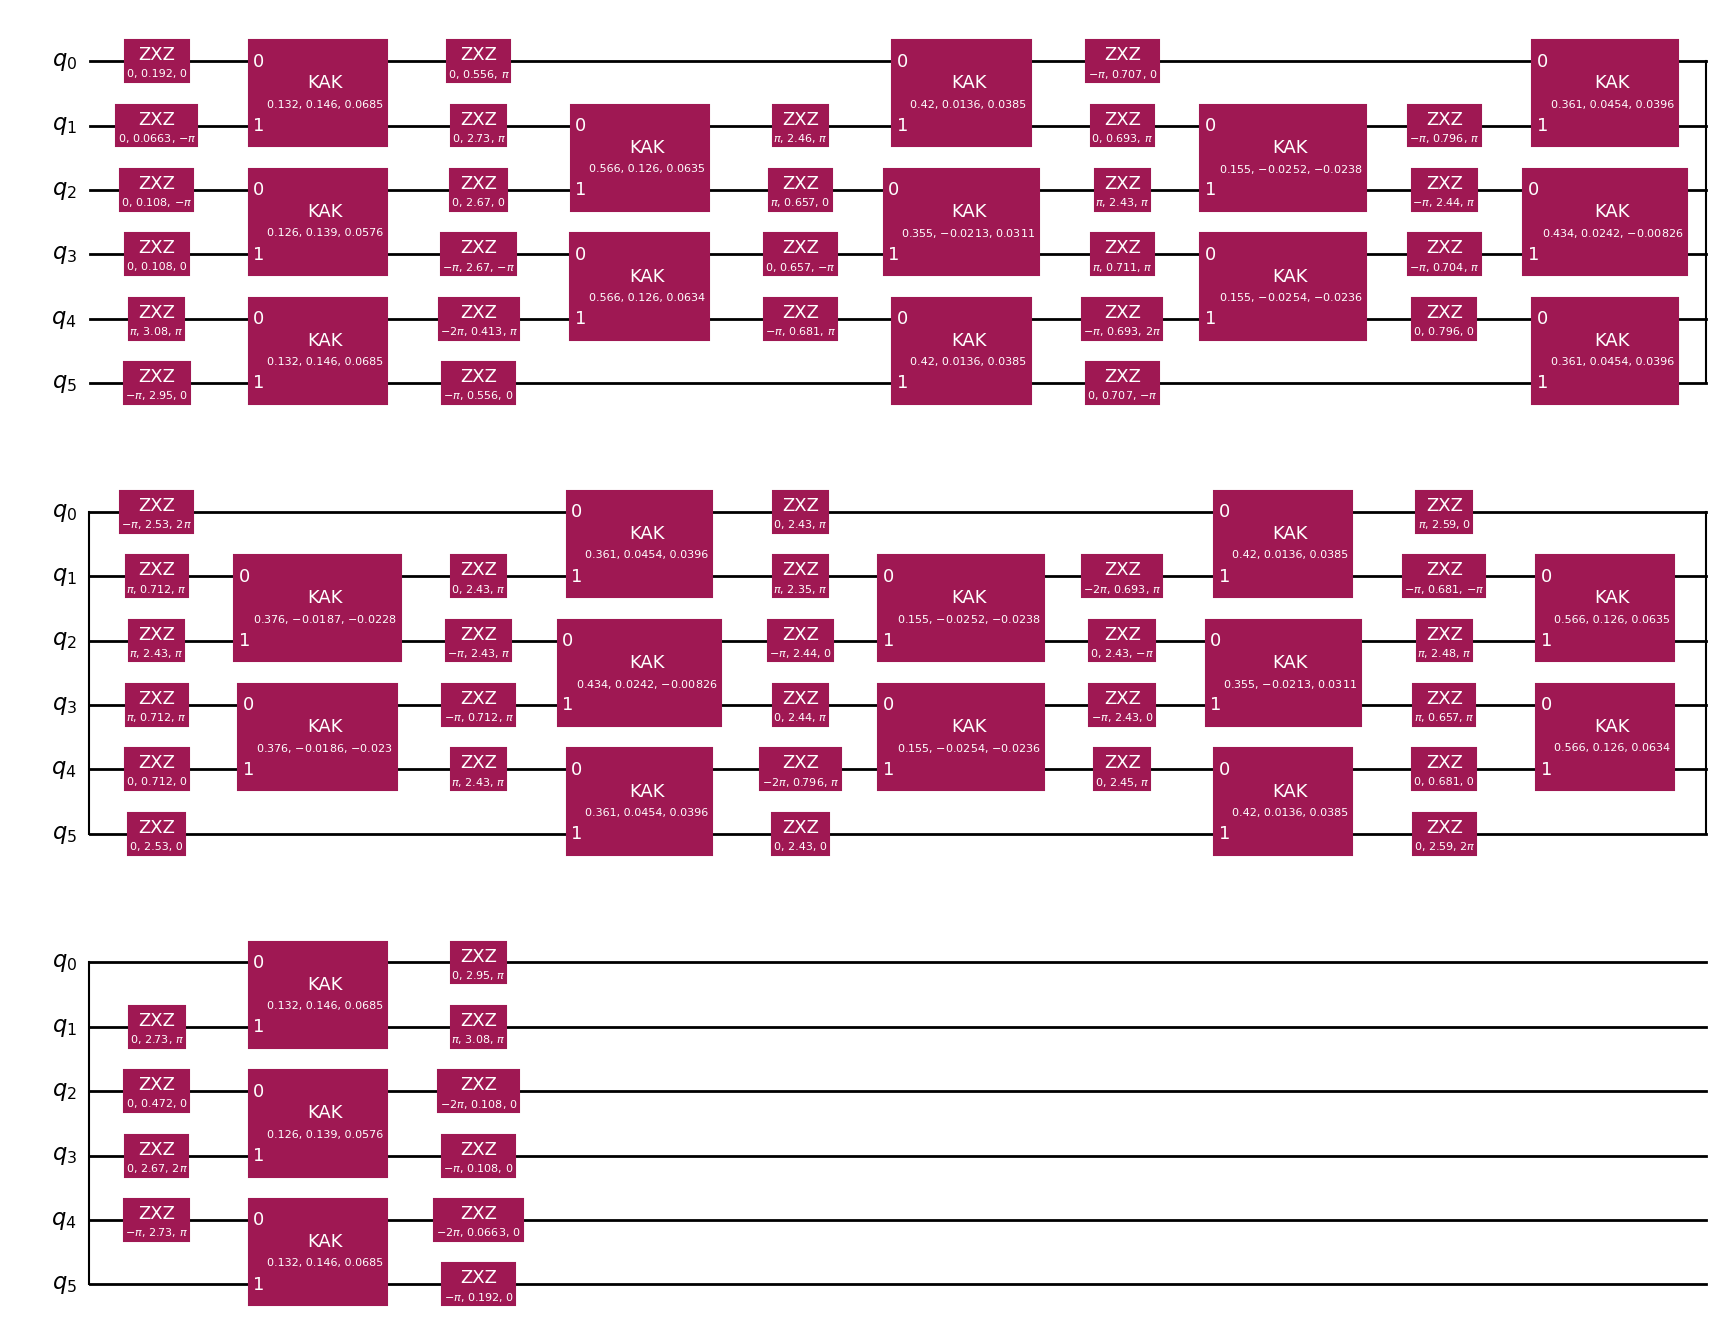

In [57]:
# from the optimised circuit 
aqc_optimised_block_h = aqc_ansatz_h.assign_parameters(aqc_final_parameters_h)
print("=== Complete Optimised Circuit ===")
aqc_optimised_block_h.draw("mpl")

In [58]:
original_depth_h = aqc_optimised_block_h.depth()
print(original_depth_h)

23


In [59]:
# calculate Frobenius inner product 
import numpy as np
from qiskit.quantum_info import Operator

if coupling_map.num_nodes() <= 8:
    target_operator_h = Operator(aqc_target_step_circuit_h).power(2**aqc_target_log2_num_trotter_steps)
    
    initial_fidelity_h = abs(
        np.trace(Operator(bw_qc_h).conjugate().to_matrix() @ target_operator_h.to_matrix())
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Initial Frobenius inner product: {initial_fidelity_h:.8}")

    final_fidelity_h = abs(
        np.trace(
            Operator(aqc_optimised_block_h).conjugate().to_matrix() @ target_operator_h.to_matrix()
        )
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Final Frobenius inner product: {final_fidelity_h:.8}")

Initial Frobenius inner product: 0.090480208
Final Frobenius inner product: 0.99962696


The final circuit implements evolution of the Hamiltonian for time = 1.0.


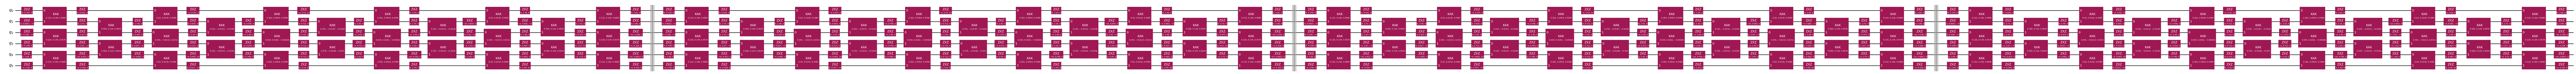

In [60]:
# Form final circuit by repeating the block
num_repeats = 4

print(
    f"The final circuit implements evolution of the Hamiltonian for time = {num_repeats * aqc_evolution_time}."
)  # FIXME: can i say anything about the fidelity??  ignoring cutoff/roundoff error of course
final_circuit_h = aqc_optimised_block_h.repeat(num_repeats)

aqc_optimised_block_h.repeat(num_repeats, insert_barriers=True).decompose().draw("mpl", fold=-1)

In [61]:
# Now slice and compress
from ropt_aqc.comparison_methods import compress_AQC_unitary

N_vals = range(1,original_depth_h+1)

df_h, aqc_ansatz_h, aqc_initial_parameters_h, aqc_final_parameters_h = compress_AQC_unitary(aqc_ansatz_h, aqc_initial_parameters_h, bw_qc_h, aqc_target_mpo_h, N_vals, simulator_settings, n_repetitions)


=== Optimizing with N = 1 layers ===
Evaluating loss function: 1.5543122e-15
Evaluating loss function: 0.02177441
Intermediate result: Fidelity 0.02177441
Evaluating loss function: 0.020780933
Evaluating loss function: 0.0213788
Evaluating loss function: 0.026822523
Intermediate result: Fidelity 0.026822523
Evaluating loss function: 0.027098214
Intermediate result: Fidelity 0.027098214
Evaluating loss function: 0.02705322
Evaluating loss function: 0.027303948
Intermediate result: Fidelity 0.027303948
Evaluating loss function: 0.027518198
Intermediate result: Fidelity 0.027518198
Evaluating loss function: 0.028049409
Evaluating loss function: 0.033665017
Evaluating loss function: 0.013301412
Evaluating loss function: 0.036605832
Evaluating loss function: 0.036835667
Intermediate result: Fidelity 0.036835667
Evaluating loss function: 0.0028154972
Evaluating loss function: 0.0062176492
Evaluating loss function: 0.036750744
Evaluating loss function: 0.036911176
Intermediate result: Fideli

In [62]:
import pandas as pd
file_path_heisenberg = f'/Users/aag/Documents/ropt-aqc/method_comparison/AQC_unitary_bw_Heisenberg_results_{t}.csv'

df_h.to_csv(file_path_heisenberg, index=False, header=True)
# df_h.to_csv(file_path_heisenberg, index=False, mode="a", header=False)

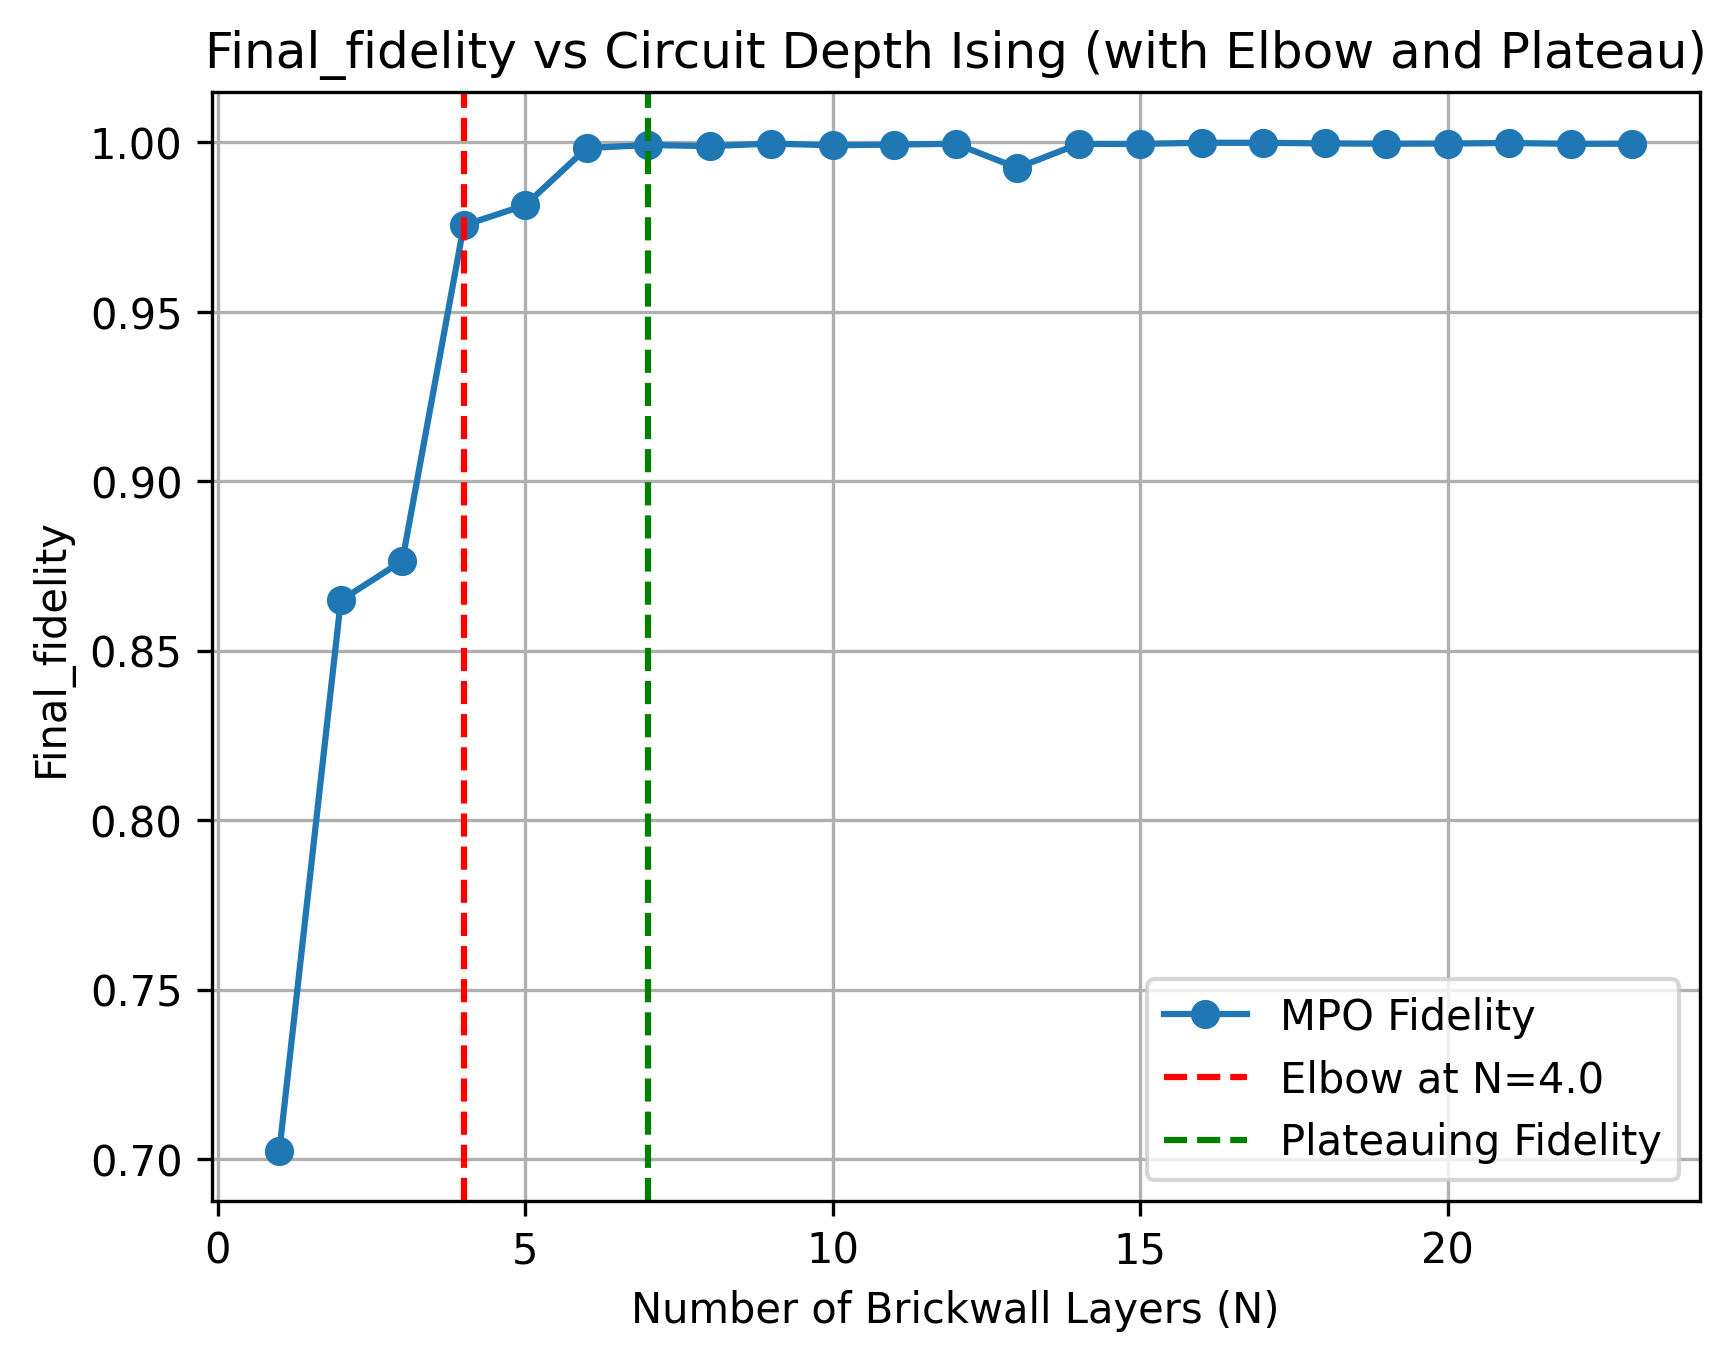


🔍 Suggested optimal compression depth: N = 7.0


In [63]:
from ropt_aqc.brickwall_opt import plot_fidelity
df_h = pd.read_csv(file_path_heisenberg)

elbow_N_h, plateau_N_h = plot_fidelity(df_h, 'Final_fidelity', t, 1e-2, method, system, save_path=True)

In [64]:
# Compress circuit
from ropt_aqc.comparison_methods import compress_AQC_unitary

N_vals = [int(plateau_N_h)]
df_compressed_h, aqc_ansatz_compressed_h, aqc_initial_parameters_compressed_h, aqc_final_parameters_compressed_h = compress_AQC_unitary(aqc_ansatz_h, aqc_initial_parameters_h, bw_qc_h, aqc_target_mpo_h, N_vals, simulator_settings, n_repetitions)


=== Optimizing with N = 7 layers ===
Evaluating loss function: 9.9920072e-16
Evaluating loss function: 0.0077103322
Intermediate result: Fidelity 0.0077103322
Evaluating loss function: 0.00090157441
Evaluating loss function: 0.010336419
Intermediate result: Fidelity 0.010336419
Evaluating loss function: 0.02815482
Intermediate result: Fidelity 0.02815482
Evaluating loss function: 0.011368516
Evaluating loss function: 0.020382083
Evaluating loss function: 0.021524761
Evaluating loss function: 0.038931212
Intermediate result: Fidelity 0.038931212
Evaluating loss function: 0.075464504
Intermediate result: Fidelity 0.075464504
Evaluating loss function: 0.17456141
Intermediate result: Fidelity 0.17456141
Evaluating loss function: 0.31012566
Intermediate result: Fidelity 0.31012566
Evaluating loss function: 0.49597474
Intermediate result: Fidelity 0.49597474
Evaluating loss function: 0.30367291
Evaluating loss function: 0.66205884
Intermediate result: Fidelity 0.66205884
Evaluating loss fun

In [66]:
print("=== Compressed Optimised Circuit ===")
aqc_optimised_compressed_h = aqc_ansatz_compressed_h.assign_parameters(aqc_final_parameters_compressed_h)
aqc_optimised_compressed_h.draw("mpl")
aqc_optimised_compressed_h.draw("mpl").savefig('optimised_circuit_AQC_bw-u_Heisenberg.pdf')


=== Compressed Optimised Circuit ===


In [67]:
print("\n=== Compressed Optimised Parameters ===")
for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed):
    print(f"{param}: {value:.6f}")


=== Compressed Optimised Parameters ===
x[0]: -2.105823
x[1]: 1.176801
x[2]: 1.233844
x[3]: -1.726878
x[4]: 1.509071
x[5]: -1.908560
x[6]: -1.320809
x[7]: 1.585553
x[8]: 4.310983
x[9]: -1.474605
x[10]: 1.524436
x[11]: 1.157450
x[12]: -2.685692
x[13]: 1.079330
x[14]: 1.489565
x[15]: -2.365907
x[16]: 2.866640
x[17]: 3.655567
x[18]: 0.536613
x[19]: 0.008898
x[20]: 0.004075
x[21]: -3.891824
x[22]: 1.230321
x[23]: -0.548279
x[24]: -0.055862
x[25]: 2.266794
x[26]: 3.909792
x[27]: 0.550092
x[28]: 0.016273
x[29]: -0.000691
x[30]: -0.107917
x[31]: 2.757671
x[32]: 0.593055
x[33]: -3.162543
x[34]: 2.691039
x[35]: -2.788221
x[36]: 0.160888
x[37]: 0.002332
x[38]: -1.424448
x[39]: -3.157090
x[40]: 4.932963
x[41]: 0.124755
x[42]: -3.638290
x[43]: 1.066783
x[44]: 2.828002
x[45]: 0.886882
x[46]: 0.246780
x[47]: -0.000401
x[48]: -3.126039
x[49]: 2.236385
x[50]: 2.863039
x[51]: -2.511097
x[52]: 0.880654
x[53]: 5.226229
x[54]: 0.835510
x[55]: -0.071111
x[56]: -0.001483
x[57]: -0.703587
x[58]: 0.893313
x[

In [69]:
print(f"Number of parameters in ansatz: {len(aqc_ansatz_compressed_h.parameters)}")
print(f"Physical depth of compressed circuit: {aqc_optimised_compressed_h.depth()}")
print(f"Compression ratio: { 83 / aqc_optimised_compressed_h.depth()}")


Number of parameters in ansatz: 90
Physical depth of compressed circuit: 7
Compression ratio: 11.857142857142858
